# Age estimation via face images

## Introduction

The Bread-Salt chain supermarket is implementing a computer vision system to process customer photos. Photo-fixing in the cash desk area will help determine the age of customers in order to:
- analyze purchases and offer products that may be of interest to customers in the same age group;
- control the integrity of cashiers when selling alcohol.

### Main goal

The main goal is to make a model that determines the approximate age of a person from a photo.

### Data

Data taken from the ChaLearn Looking at People website: folder with images and a CSV file labels.csv with the following two columns:

- file_name — name of the file with person's photo;
- real_age — age of a person (target variable).

### Metrics

The quality metric will be the MAE (which must be less than 7).

## Exploratory Data Analysis

Import necessary libraries.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Import the table, where all the photos indicated by age.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Let's display the basic information about the dataframe.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Apparently there are no missing data, the age is in "int" format. All this is good. But the data, in my opinion, is not enough.

In [4]:
print('Number of duplicates in the data:', labels.duplicated().sum())

Количество дубликатов в данных: 0


Let's see what's inside.

In [5]:
labels.sample(10)

file_name  real_age
7127  007143.jpg        28
3459  003459.jpg        46
2540  002540.jpg        28
4757  004757.jpg        43
61    000061.jpg        24
5946  005947.jpg        41
4007  004007.jpg        32
5992  005993.jpg        54
256   000256.jpg        39
6719  006726.jpg        12

Let's look at the main statistical characteristics of the age distribution.

In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Min and max values are adequate. The median is 29. Definitely not an aging nation. Let's look at the histogram of the age distribution.

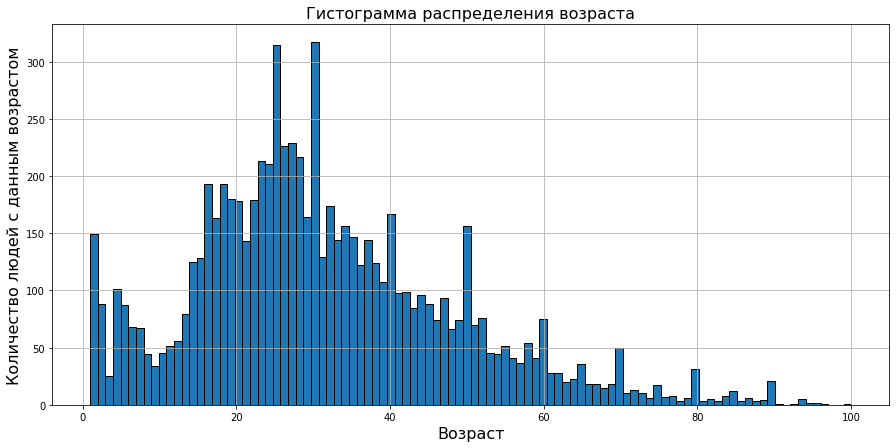

In [7]:
labels.hist(bins = 100, edgecolor = 'black', figsize = (15,7))
plt.title('Histogram of age distribution', fontsize=16)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Number of people', fontsize=16)
plt.show()

The distribution looks adequate, there is a slight peak around 1 year oдв (almost 150 people).

Let's also load the data using ImageDataGenerator. Let's call the 'flow_from_directory' function to load the data from the folder. The size of the image will be 224 by 224, the size of one byte will be set to 32.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Now let's display 15 images on the screen. We have to make sure that the people's faces are really there.

In [9]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

### Conclusion after Exploratory Data Analysis:

In my opinion, the age distribution in the selection looks adequate. It sometimes seems like a person doesn't look their age from the photo, which will probably have a favorable effect on the model, it will help her learn from the different examples. Some images are cropped or rotated. Augmentations may be needed, but in limited quantities.

Here's a question. In which region of Russia is this store going to organize its activities? According to Rosstat 2017, the average age is 29 in the peoples of the Caucasian republics, while in most European regions of Russia the average age is over 40. It would be more appropriate to use a sample where the average real age would be something between these two values.

# Model training and testing

Let's load the training sample into the load_train(path) function and return the pair with the variables 'features and target feature'. The path to the files is in the path parametr.

Let's do the same with the load_test(path) function.

Let's create a model for the neural network and return it with the return command ('create_model(input_shape)' function). To specify the size of the data in the first layer, apply the 'input_shape' parameter.

Let's create a function to teach the model (train_model). 
The function receives as input:
- model;
- training and test samples;
- arguments for the fit() method.

In [10]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Train for 356 steps, validate for 119 steps

Epoch 1/15

356/356 - 81s - loss: 205.1859 - mae: 10.4231 - val_loss: 612.0026 - val_mae: 19.7149

Epoch 2/15

356/356 - 44s - loss: 87.0230 - mae: 7.0476 - val_loss: 217.8162 - val_mae: 10.9644

Epoch 3/15

356/356 - 56s - loss: 59.1155 - mae: 5.8267 - val_loss: 97.3415 - val_mae: 7.6701

Epoch 4/15

356/356 - 55s - loss: 42.7481 - mae: 5.0047 - val_loss: 80.5876 - val_mae: 6.8792

Epoch 5/15

356/356 - 47s - loss: 30.8056 - mae: 4.2920 - val_loss: 76.5356 - val_mae: 6.8639

Epoch 6/15

356/356 - 56s - loss: 24.9316 - mae: 3.8238 - val_loss: 73.5600 - val_mae: 6.4722

Epoch 7/15

356/356 - 53s - loss: 19.8868 - mae: 3.3957 - val_loss: 68.8543 - val_mae: 6.2578

Epoch 8/15

356/356 - 46s - loss: 16.1140 - mae: 3.0917 - val_loss: 67.6185 - val_mae: 6.3836

Epoch 9/15

356/356 - 42s - loss: 14.1784 - mae: 2.8854 - val_loss: 61.1700 - val_mae: 5.8013

Epoch 10/15

356/356 - 43s - loss: 12.8970 - mae: 2.7284 - val_loss: 63.3233 - val_mae: 5.9499

Epoch 11/15

356/356 - 41s - loss: 12.7912 - mae: 2.7231 - val_loss: 68.9559 - val_mae: 6.2242

Epoch 12/15

356/356 - 42s - loss: 12.0199 - mae: 2.6498 - val_loss: 59.5471 - val_mae: 5.8553

Epoch 13/15
356/356 - 56s - loss: 12.1393 - mae: 2.6574 - val_loss: 72.9302 - val_mae: 6.5904

Epoch 14/15

356/356 - 55s - loss: 11.5502 - mae: 2.6102 - val_loss: 75.4791 - val_mae: 6.4958

Epoch 15/15

356/356 - 46s - loss: 10.6502 - mae: 2.4912 - val_loss: 56.2715 - val_mae: 5.6172

119/119 - 11s - loss: 56.2715 - mae: 5.6172

Test MAE: 5.6172

### Analysis of the trained model

The model we used was based on ResNet50. 
- To adapt ResNet to the task, we removed the top of the architecture and made it ourselves. We left only one neuron at the end of the network. 
- The activation function was ReLU, since we had a regression task. 
- The metric and loss function was MAE. 
- The learning algorithm of the neural network was Adam with learning rate=0.0001 (lr). 
- The number of epochs was 15. 
- Only horizontal reflection was used as augmentations.

The model we developed succeeded in the task. The MAE on the test sample = 5.6, which is lower than the requested 7.

# Conclusion

We had the task of developing a computer vision system for the Bread-Salt supermarket, capable of determining the age of customers by photo.
<br>
The following conclusions and results were obtained:
<br>
- the images presented for training are valid material for the development of the model. Due to the age distribution of faces in the images, we recommend using this model in regions with a younger population.
- the ResNet50 architecture was proposed to solve the problem. It successfully completed the task, demonstrating an MAE of less than 6. This means that the age of the customers will be determined within this error.